### Ensemble Methods Section 35

### Questions

### Objectives
YWBAT
- Compare and contrast decision trees with Random Forest Models
- Compare and contrast ADABoost with Gradient Boosting
- Condition our data for a single model
- Tune hyperparameters to increase desired metric
- Analyze model for use case
- Build a pipeline that will analyze an individual patient

### What is a random forest?
A random forest is a collection of decision trees where each decision tree is built by:
    - randomly sampling features of our data
    - randomly sampling data to train on
    - Bootstrap sample our data to train


How are points classified in a random forest?
- The point drops into every decision of our forest until
- The point then gets classified by every tree
- Majority vote on classification to classify our point


### Real Life Structures
- Forests with 20, 100, 1000 trees
- Tree Depth - 5 layers, 10 layers, 20 layers, etc


### Analyze 

### Adaboosting - sampling
- Steps to perform Adaptive Boosting
    - 0: Trains on training data
    - 1: Split Train Data in/out 70/30
        - The first split is truly random
    - 2: Build stump on in sample (70%)
    - 3: calculate error on out of bag of sample
    - 4a: Increase weights of out of bag samples that are incorrect
    - 4b: Decrease weights of out of bag samples that are correct
    - 5: Build next stump
    - Repeat 1 - 5
    - Aggregate voting 
    
    
![](images/adaboost.jpg)



### Gradient boosting - residuals
- How does this work for linreg/logistic? 
    - Minimizes the loss function by taking steps
        - Taking steps on our Loss_Function as a function of our coefficients (parameters)
- But Tree models are non parametric
    - 

![](images/gradboost.png)

### to use XGBOOST use
```import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'```

### Outline

In [12]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from mlxtend.feature_selection import SequentialFeatureSelector as sfs

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

### Let's build some models

In [2]:
df = pd.read_csv("./pima-indians-diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### No data cleaning needed

### Look at class counts

In [5]:
df.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

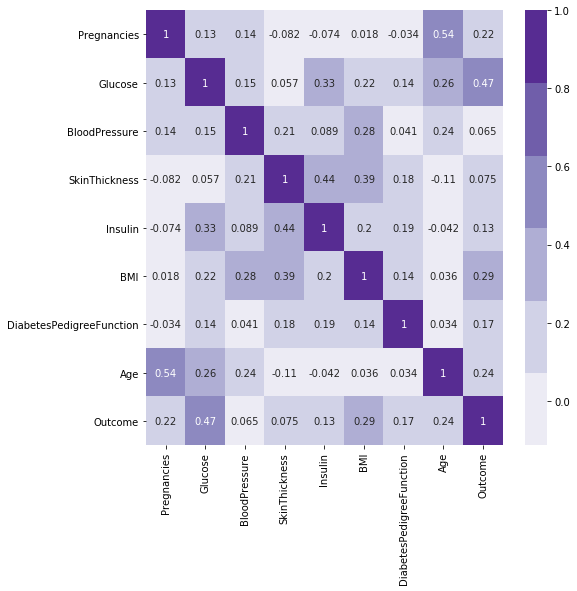

In [6]:
corr = df.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr, cmap=sns.color_palette('Purples'), annot=True)
plt.show()

### How does multicollinearity affect our model?
- Makes it difficult to interpret
    - Feature importances become difficult to interpret

In [8]:
x, y = df.drop('Outcome', axis=1), df["Outcome"]

In [10]:
def make_model(xtrain, ytrain, weights=None):
    if weights:
        print(f"Weights Used: {weights}")
    clf = RandomForestClassifier(n_estimators=20, min_samples_leaf=15, class_weight=weights)
    clf.fit(xtrain, ytrain)
    train_score = clf.score(xtrain, ytrain)
    test_score = clf.score(xtest, ytest)
    print(f"Train Score = {train_score}\nTest Score = {test_score}")
    print("Returning Classifier")
    return clf

In [36]:
### Baseline with all features
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.20)

In [37]:
clf = make_model(xtrain, ytrain)

Train Score = 0.7996742671009772
Test Score = 0.7792207792207793
Returning Classifier


In [38]:
feature_scores = clf.feature_importances_
features = x.columns

In [39]:
def plot_features(features, feature_scores):
    plt.figure(figsize=(8, 5))
    plt.grid(linestyle='dashed')
    plt.bar(features, feature_scores)
    plt.xticks(rotation=75)
    plt.ylabel("Feature Importance")
    plt.show()

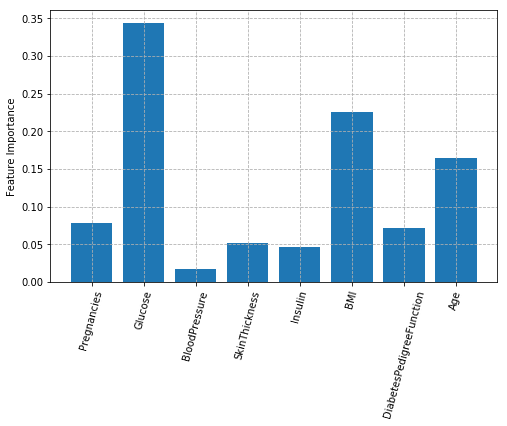

In [40]:
plot_features(features, feature_scores)

### Using SelectKBest to find the best K Features to Use

In [24]:
# you should condition data first
kbest = SelectKBest(k=5)

In [25]:
x_new = kbest.fit_transform(x, y)
x_new

array([[  6.   , 148.   ,  33.6  ,   0.627,  50.   ],
       [  1.   ,  85.   ,  26.6  ,   0.351,  31.   ],
       [  8.   , 183.   ,  23.3  ,   0.672,  32.   ],
       ...,
       [  5.   , 121.   ,  26.2  ,   0.245,  30.   ],
       [  1.   , 126.   ,  30.1  ,   0.349,  47.   ],
       [  1.   ,  93.   ,  30.4  ,   0.315,  23.   ]])

In [26]:
df.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


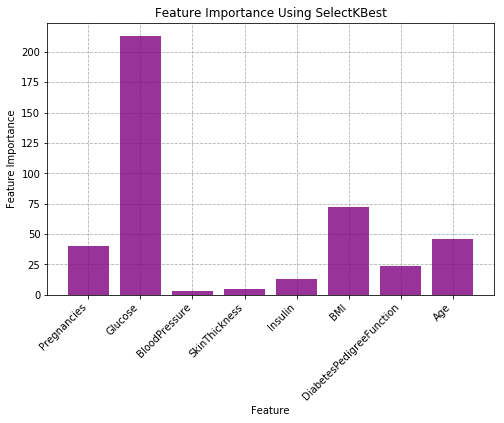

In [27]:
kbest.scores_ # these are the feature important scores for all the columns
plt.figure(figsize=(8, 5))
plt.grid(linestyle='dashed', zorder=1)
plt.bar(x.columns, kbest.scores_, zorder=2, color='purple', alpha=0.8)
plt.xticks(x.columns, x.columns, rotation=45, ha='right')
plt.ylabel("Feature Importance")
plt.xlabel("Feature")
plt.title("Feature Importance Using SelectKBest")
plt.show()

In [41]:
kbest.get_support() # Boolean list stating if a column was chosen or not

array([ True,  True, False, False, False,  True,  True,  True])

In [42]:
# using kbest.get_support() let's extract these columns from our dataframe
cols = x.columns[kbest.get_support()]
cols

Index(['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype='object')

### Build a model using the best features from SelectKBest

In [44]:
x1 = df[cols]
y = df['Outcome']

In [66]:
xtrain, xtest, ytrain, ytest = train_test_split(x1, y, train_size=0.80)

In [67]:
xtrain.shape

(614, 5)

In [68]:
clf = make_model(xtrain, ytrain)

Train Score = 0.8061889250814332
Test Score = 0.7662337662337663
Returning Classifier


### Now what do we do? 

In [69]:
def make_weights(ytrain):
    # inverse proportion 0s = 66% -> w0 = 33%
    total_0s = ytrain.value_counts()[0]
    total_1s = ytrain.value_counts()[1]
    total_labels = total_0s + total_1s
    
    w0 = 1 - total_0s / total_labels
    w1 = 1 - total_1s / total_labels
    d = {0: w0, 1: w1}
    return d

In [70]:
# Let's handle class imbalance
# increase weights for train/test split
weights = make_weights(ytrain)
clf = make_model(xtrain, ytrain, weights=weights)

Weights Used: {0: 0.35016286644951145, 1: 0.6498371335504887}
Train Score = 0.8127035830618893
Test Score = 0.7532467532467533
Returning Classifier


# Using Step Forward Selection
### Another way to choose features is using Step Foward Selection
[source here](https://www.kdnuggets.com/2018/06/step-forward-feature-selection-python.html)

In [71]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.20)

In [82]:
clf = RandomForestClassifier(n_estimators=20, n_jobs=-1)

# Build step forward feature selection to find 3 best features 
# notice this is using 'accuracy' as our metric
sfs1 = sfs(clf,
           k_features=5,
           forward=False,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(xtrain, ytrain)

### let's look at the features that were chosen

In [83]:
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[0, 1, 2, 3, 4]


In [84]:
### Using these features let's build a model
cols = x.columns[feat_cols]
cols

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin'], dtype='object')

In [85]:
x_3 = x[cols]
xtrain, xtest, ytrain, ytest = train_test_split(x_3, y, test_size=0.20)

In [86]:
clf = make_model(xtrain, ytrain)

Train Score = 0.7850162866449512
Test Score = 0.7467532467532467
Returning Classifier


In [87]:
ypreds = clf.predict(xtest)
cm = confusion_matrix(ytest, ypreds)

Text(0.5, 1.0, 'Confusion Matrix')

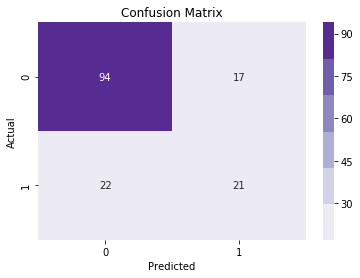

In [88]:
sns.heatmap(cm, cmap=sns.color_palette('Purples'), annot=True, fmt='0.2g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

### Repeat but with recall

In [89]:
from sklearn.metrics import recall_score, make_scorer

In [93]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Build step forward feature selection to find 3 best features 
# notice this is using 'accuracy' as our metric
sfs1 = sfs(clf,
           k_features=5,
           forward=True,
           floating=False,
           verbose=2,
           scoring=make_scorer(recall_score),
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(xtrain, ytrain)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.5s finished

[2019-08-07 14:49:44] Features: 1/5 -- score: 0.4844444444444445[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.1s finished

[2019-08-07 14:49:49] Features: 2/5 -- score: 0.5733333333333333[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.8s finished

[2019-08-07 14:49:53] Features: 3/5 -- score: 0.5733333333333334[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

In [95]:
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[0, 1, 2, 3, 4]


In [96]:
### Using these features let's build a model
cols = x.columns[feat_cols]
cols

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin'], dtype='object')

In [97]:
x_3 = x[cols]
xtrain, xtest, ytrain, ytest = train_test_split(x_3, y, test_size=0.20)

In [98]:
clf = make_model(xtrain, ytrain)

Train Score = 0.7866449511400652
Test Score = 0.6948051948051948
Returning Classifier


In [99]:
ypreds = clf.predict(xtest)
cm = confusion_matrix(ytest, ypreds)

Text(0.5, 1.0, 'Confusion Matrix')

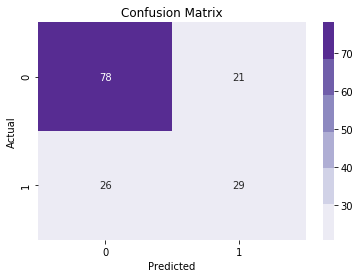

In [100]:
sns.heatmap(cm, cmap=sns.color_palette('Purples'), annot=True, fmt='0.2g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Scale our features and run another baseline
### Let's scale our features and rerun our models


In [101]:
x = df.drop("Outcome", axis=1)
y = df.Outcome
x.shape, y.shape

((768, 8), (768,))

In [102]:
scaler = StandardScaler()

In [103]:
x_scaled = scaler.fit_transform(x)

In [106]:
xtrain, xtest, ytrain, ytest = train_test_split(x_scaled, y, test_size=0.20)

In [107]:
make_model(xtrain, ytrain)

Train Score = 0.8013029315960912
Test Score = 0.7662337662337663
Returning Classifier


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [108]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Build step forward feature selection to find 3 best features 
# notice this is using 'accuracy' as our metric
sfs1 = sfs(clf,
           k_features=3,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(xtrain, ytrain)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    9.5s finished

[2019-08-07 14:51:13] Features: 1/3 -- score: 0.7033315705975673[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    8.5s finished

[2019-08-07 14:51:22] Features: 2/3 -- score: 0.7263088313061872[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    7.8s finished

[2019-08-07 14:51:29] Features: 3/3 -- score: 0.7555790586991009

In [109]:
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[1, 5, 7]


In [110]:
### Using these features let's build a model
cols = x.columns[feat_cols]
cols

Index(['Glucose', 'BMI', 'Age'], dtype='object')

In [111]:
x_3 = x[cols]
xtrain, xtest, ytrain, ytest = train_test_split(x_3, y, test_size=0.20)

In [112]:
clf = make_model(xtrain, ytrain)

Train Score = 0.8029315960912052
Test Score = 0.7857142857142857
Returning Classifier


In [113]:
ypreds = clf.predict(xtest)
cm = confusion_matrix(ytest, ypreds)

Text(0.5, 1.0, 'Confusion Matrix')

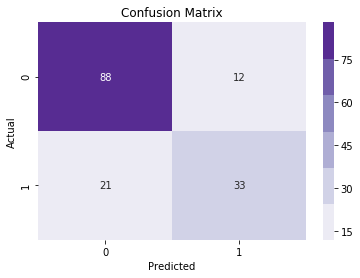

In [114]:
sns.heatmap(cm, cmap=sns.color_palette('Purples'), annot=True, fmt='0.2g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

### Now let us run some LDA

In [115]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [116]:
lda = LinearDiscriminantAnalysis(n_components=5)

In [127]:
x_lda = lda.fit_transform(x, y)

/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(8, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


In [128]:
xtrain, xtest, ytrain, ytest = train_test_split(x_lda, y, test_size=0.20)

In [129]:
make_model(xtrain, ytrain)

Train Score = 0.8013029315960912
Test Score = 0.7922077922077922
Returning Classifier


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Pros of LDA: Separates your classes as much as possible

Cons: Lose all feature interpretability

In [203]:
xtrain, xtest, ytrain, ytest = train_test_split(x.Glucose, y, test_size=0.20)

In [210]:
clf = AdaBoostClassifier(n_estimators=10, learning_rate=1.0, random_state=42)
clf.fit(xtrain.values.reshape(-1, 1), ytrain)
train_score = clf.score(xtrain.values.reshape(-1, 1), ytrain)
test_score = clf.score(xtest.values.reshape(-1, 1), ytest)
print(f"Train Score = {train_score}\nTest Score = {test_score}")

Train Score = 0.752442996742671
Test Score = 0.7272727272727273


In [178]:
clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, random_state=42)
clf.fit(xtrain, ytrain)
train_score = clf.score(xtrain, ytrain)
test_score = clf.score(xtest, ytest)
print(f"Train Score = {train_score}\nTest Score = {test_score}")

Train Score = 0.8827361563517915
Test Score = 0.7597402597402597


### Assessment

In [193]:
clf.estimators_[2]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1935803228, splitter='best')

In [194]:
xtrain.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin
145,0,102,75,23,0
586,8,143,66,0,0
297,0,126,84,29,215
369,1,133,102,28,140
536,0,105,90,0,0


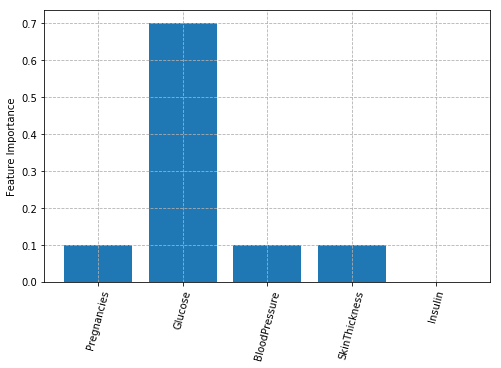

In [195]:
plot_features(x.drop(["BMI", "Age", "DiabetesPedigreeFunction"], axis=1).columns, clf.feature_importances_)

In [200]:
glucose_0 = df.loc[df.Outcome==0, 'Insulin']
glucose_1 = df.loc[df.Outcome==1, 'Insulin']

(array([141.,   6.,  23.,  33.,  24.,  12.,   7.,   7.,   2.,   1.,   1.,
          5.,   3.,   1.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([  0. ,  42.3,  84.6, 126.9, 169.2, 211.5, 253.8, 296.1, 338.4,
        380.7, 423. , 465.3, 507.6, 549.9, 592.2, 634.5, 676.8, 719.1,
        761.4, 803.7, 846. ]),
 <a list of 20 Patch objects>)

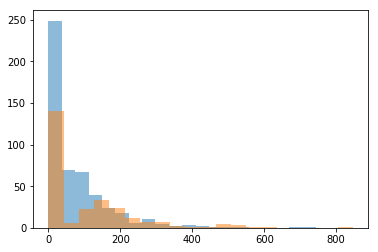

In [201]:
plt.hist(glucose_0, bins=20, alpha=0.5)
plt.hist(glucose_1, bins=20, alpha=0.5)